# Chapter 2 - Financial Data Structures

### Exercise 2.1
**Note:** Adapted for SOLUSDT for a year long dataset from Binance
(Concretely the spans approximately 13 months: October 16, 2024 to October 17, 2025)

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import time

# for the classes to handle dynamic thresholds
import json
from dataclasses import dataclass

from scipy import stats

In [2]:
@dataclass
class BarThresholds:
    """Store and manage bar formation thresholds"""
    tick_threshold: int
    volume_threshold: float
    dollar_threshold: float
    target_bars: int
    data_span_days: int
    
    def to_dict(self):
        return {
            'tick_threshold': self.tick_threshold,
            'volume_threshold': float(self.volume_threshold),
            'dollar_threshold': float(self.dollar_threshold),
            'target_bars': self.target_bars,
            'data_span_days': self.data_span_days
        }
    
    def save(self, filepath):
        Path(filepath).parent.mkdir(parents=True, exist_ok=True)
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)
        print(f"✓ Thresholds saved to {filepath}")
    
    @staticmethod
    def load(filepath):
        with open(filepath, 'r') as f:
            d = json.load(f)
        return BarThresholds(**d)

    def display(self):
        """Pretty print threshold information"""
        print(f"\n{'='*60}")
        print(f"BAR FORMATION THRESHOLDS")
        print(f"{'='*60}")
        print(f"Tick threshold:    {self.tick_threshold:,} ticks per bar")
        print(f"Volume threshold:  {self.volume_threshold:,.2f} SOL per bar")
        print(f"Dollar threshold:  ${self.dollar_threshold:,.0f} per bar")
        print(f"Target bars:       {self.target_bars:,}")
        print(f"Data span:         {self.data_span_days} days")
        print(f"{'='*60}\n")


In [3]:
# Load one file to inspect
data_dir = Path('../binance_raw_data/SOLUSDT')
sample_file = data_dir / '2025-07-09.parquet'

df = pd.read_parquet(sample_file)

# Basic inspection
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Shape: (245177, 6)

Columns: ['timestamp', 'symbol', 'price', 'quantity', 'dollar_volume', 'is_buyer_maker']

First few rows:
                timestamp   symbol   price  quantity  dollar_volume  \
0 2025-07-08 16:00:00.004  SOLUSDT  149.84    12.336     1848.42624   
1 2025-07-08 16:00:00.006  SOLUSDT  149.84    49.222     7375.42448   
2 2025-07-08 16:00:00.015  SOLUSDT  149.84    24.282     3638.41488   
3 2025-07-08 16:00:00.133  SOLUSDT  149.84    95.311    14281.40024   
4 2025-07-08 16:00:00.136  SOLUSDT  149.84     4.519      677.12696   

   is_buyer_maker  
0           False  
1           False  
2           False  
3           False  
4           False  

Data types:
timestamp         datetime64[ns]
symbol                    object
price                    float64
quantity                 float64
dollar_volume            float64
is_buyer_maker              bool
dtype: object


Let's start by importing a sample of the raw predownloaded SOL data into the notebook

lets view a single day...

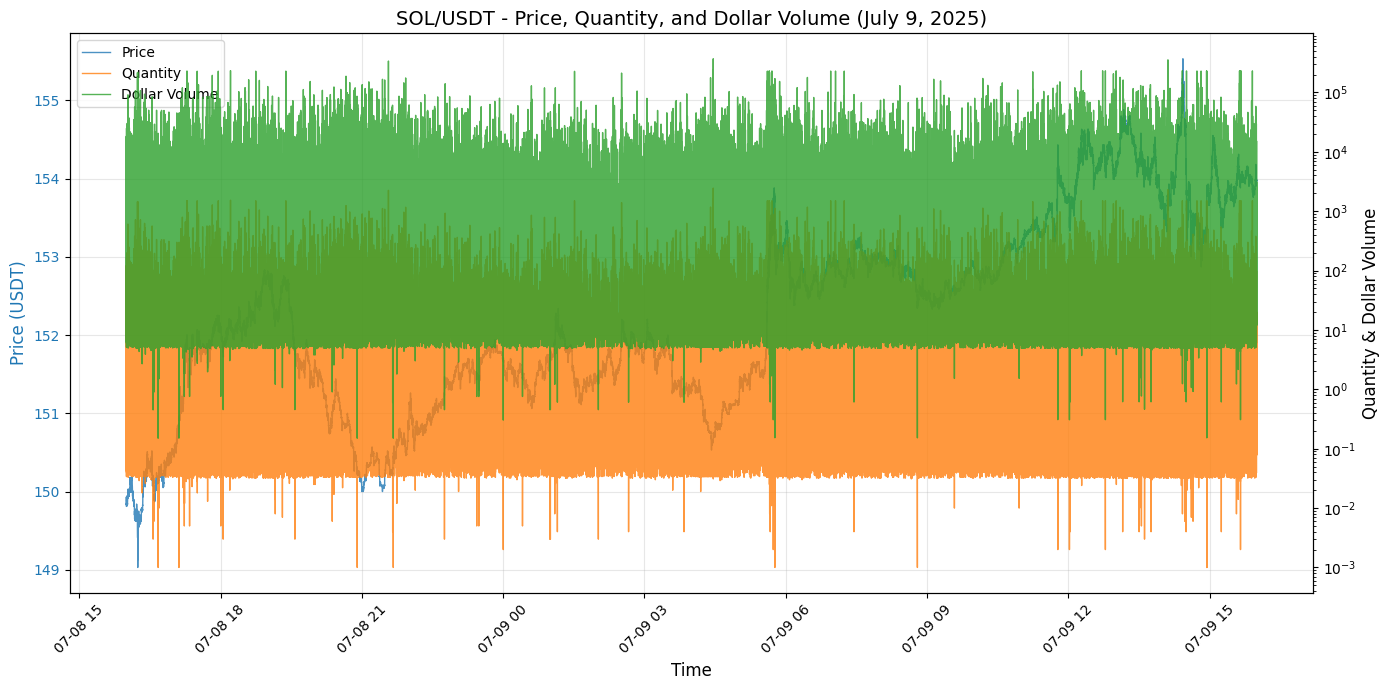

In [4]:
# Plot price, quantity, and dollar_volume with dual y-axes just to see it
import matplotlib.pyplot as plt

# Set timestamp as the index
df_sorted = df.sort_values('timestamp')
df_sorted.set_index('timestamp', inplace=True)

# Create figure with two y-axes (because scales are very different)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price on the left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Price (USDT)', color=color1, fontsize=12)
line1 = ax1.plot(df_sorted.index, df_sorted['price'], color=color1, linewidth=1, label='Price', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create a second y-axis on the right for quantity and dollar_volume
ax2 = ax1.twinx()
color2 = 'tab:orange'
color3 = 'tab:green'
ax2.set_ylabel('Quantity & Dollar Volume', fontsize=12)

# Plot quantity and dollar_volume on log scale (right y-axis)
line2 = ax2.plot(df_sorted.index, df_sorted['quantity'], color=color2, linewidth=1, label='Quantity', alpha=0.8)
line3 = ax2.plot(df_sorted.index, df_sorted['dollar_volume'], color=color3, linewidth=1, label='Dollar Volume', alpha=0.8)

# Use log scale on the right y-axis to handle the large range
ax2.set_yscale('log')

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add title
ax1.set_title('SOL/USDT - Price, Quantity, and Dollar Volume (July 9, 2025)', fontsize=14)

# Combine legends from both axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

# Tight layout to prevent label cutoff
plt.tight_layout()

plt.show()

Now lets import the entire series of data

In [5]:
# Load all parquet files
all_files = sorted(data_dir.glob('*.parquet'))
print(f"Found {len(all_files)} files")

# Concatenate all files
df_all = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)

print(f"\nTotal ticks: {len(df_all):,}")
print(f"Date range: {df_all['timestamp'].min()} to {df_all['timestamp'].max()}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1e6:.2f} MB")

Found 390 files

Total ticks: 196,476,156
Date range: 2024-09-23 16:00:00.118000 to 2025-10-18 15:59:59.951000
Memory usage: 17486.38 MB


### 2.1 On a series of SOLUSDT tick data...

#### (2.1a) Form tick, volume, and dollar bars.

In [6]:
# Optimised Tick Bars
def form_tick_bars_fast(df, tick_threshold):
    """
    Vectorised tick bar formation - slices instead of row-by-row
    """
    n_bars = len(df) // tick_threshold
    
    # Pre-allocate arrays for speed
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    for i in range(n_bars):
        start_idx = i * tick_threshold
        end_idx = start_idx + tick_threshold
        
        timestamps[i] = times[end_idx - 1]
        opens[i] = prices[start_idx]
        highs[i] = prices[start_idx:end_idx].max()
        lows[i] = prices[start_idx:end_idx].min()
        closes[i] = prices[end_idx - 1]
        volumes[i] = quantities[start_idx:end_idx].sum()
        dollar_volumes[i] = dollars[start_idx:end_idx].sum()
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': tick_threshold
    })

# Tick Bar Function
def form_tick_bars(df, tick_threshold):
    """
    Form tick bars - sample every N ticks
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    tick_threshold : int
        Number of ticks per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    
    for i in range(0, len(df), tick_threshold):
        # Get chunk of ticks
        chunk = df.iloc[i:i+tick_threshold]
        
        if len(chunk) == 0:
            continue
            
        bar = {
            'timestamp': chunk['timestamp'].iloc[-1],  # Close time
            'open': chunk['price'].iloc[0],
            'high': chunk['price'].max(),
            'low': chunk['price'].min(),
            'close': chunk['price'].iloc[-1],
            'volume': chunk['quantity'].sum(),
            'dollar_volume': chunk['dollar_volume'].sum(),
            'num_ticks': len(chunk)
        }
        bars.append(bar)
    
    return pd.DataFrame(bars)

In [7]:
# Optimised Volume Bars
def form_volume_bars_fast(df, volume_threshold):
    """
    Vectorised volume bar formation using cumsum + searchsorted
    """
    # Cumulative volume
    cumsum_volume = df['quantity'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(volume_threshold, cumsum_volume[-1], volume_threshold)
    bar_indices = np.searchsorted(cumsum_volume, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays for speed
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })


# Volume Bar Function
def form_volume_bars(df, volume_threshold):
    """
    Form volume bars - sample every N units of volume (SOL)
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    volume_threshold : float
        Volume in SOL per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    cumulative_volume = 0
    bar_start_idx = 0
    
    for i in range(len(df)):
        cumulative_volume += df.iloc[i]['quantity']
        
        # When threshold reached, close the bar
        if cumulative_volume >= volume_threshold:
            chunk = df.iloc[bar_start_idx:i+1]
            
            bar = {
                'timestamp': chunk['timestamp'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['quantity'].sum(),
                'dollar_volume': chunk['dollar_volume'].sum(),
                'num_ticks': len(chunk)
            }
            bars.append(bar)
            
            # Reset for next bar
            cumulative_volume = 0
            bar_start_idx = i + 1
    
    return pd.DataFrame(bars)

In [8]:
# Optimised Dollar Bars
def form_dollar_bars_fast(df, dollar_threshold):
    """
    Vectorised dollar bar formation using cumsum + searchsorted
    """
    # Cumulative dollar volume
    cumsum_dollars = df['dollar_volume'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(dollar_threshold, cumsum_dollars[-1], dollar_threshold)
    bar_indices = np.searchsorted(cumsum_dollars, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })

# Dollar Bar Function
def form_dollar_bars(df, dollar_threshold):
    """
    Form dollar bars - sample every N dollars exchanged
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    dollar_threshold : float
        Dollar volume in USDT per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    cumulative_dollars = 0
    bar_start_idx = 0
    
    for i in range(len(df)):
        cumulative_dollars += df.iloc[i]['dollar_volume']
        
        # When threshold reached, close the bar
        if cumulative_dollars >= dollar_threshold:
            chunk = df.iloc[bar_start_idx:i+1]
            
            bar = {
                'timestamp': chunk['timestamp'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['quantity'].sum(),
                'dollar_volume': chunk['dollar_volume'].sum(),
                'num_ticks': len(chunk)
            }
            bars.append(bar)
            
            # Reset for next bar
            cumulative_dollars = 0
            bar_start_idx = i + 1
    
    return pd.DataFrame(bars)

a quick test (before loading all data)

In [9]:
# Test on small sample first
print("Testing optimised functions on 1M ticks...")
test_sample = df_all.head(1_000_000)

start = time.time()
tick_bars_test = form_tick_bars(test_sample, tick_threshold=14_936)
print(f"Tick bars: {len(tick_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
volume_bars_test = form_volume_bars(test_sample, volume_threshold=285.42)
print(f"Volume bars: {len(volume_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
dollar_bars_test = form_dollar_bars(test_sample, dollar_threshold=33_111_838)
print(f"Dollar bars: {len(dollar_bars_test)} bars in {time.time()-start:.2f}s")

Testing optimised functions on 1M ticks...
Tick bars: 67 bars in 0.01s
Volume bars: 32623 bars in 44.47s
Dollar bars: 51 bars in 33.95s


In [10]:
# Form all three bar types

# Choose thresholds (we will later tune these values based on initial data)

print("Forming tick bars...")
start = time.time()
tick_bars = form_tick_bars(df_all, tick_threshold=1000)
print(f"✓ Tick bars: {len(tick_bars):,} bars in {time.time()-start:.2f}s\n")

print("Forming volume bars...")
start = time.time()
volume_bars = form_volume_bars(df_all, volume_threshold=10.0)
print(f"✓ Volume bars: {len(volume_bars):,} bars in {time.time()-start:.2f}s\n")

print("Forming dollar bars...")
start = time.time()
dollar_bars = form_dollar_bars(df_all, dollar_threshold=1_000_000)
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {time.time()-start:.2f}s")

Forming tick bars...
✓ Tick bars: 196,477 bars in 39.09s

Forming volume bars...
✓ Volume bars: 46,120,584 bars in 16620.85s

Forming dollar bars...
✓ Dollar bars: 295,542 bars in 5677.35s


In [11]:
# Inspect the results
print("=" * 60)
print("TICK BARS")
print("=" * 60)
print(tick_bars.head())
print(f"\nShape: {tick_bars.shape}")

print("\n" + "=" * 60)
print("VOLUME BARS")
print("=" * 60)
print(volume_bars.head())
print(f"\nShape: {volume_bars.shape}")

print("\n" + "=" * 60)
print("DOLLAR BARS")
print("=" * 60)
print(dollar_bars.head())
print(f"\nShape: {dollar_bars.shape}")

TICK BARS
                timestamp    open    high     low   close     volume  \
0 2024-09-23 16:05:17.292  144.20  144.73  144.07  144.69   9780.339   
1 2024-09-23 16:08:53.664  144.70  145.03  144.53  144.54  16311.296   
2 2024-09-23 16:12:24.229  144.54  144.54  143.96  144.30  13904.051   
3 2024-09-23 16:16:02.725  144.30  144.34  143.75  143.87  16044.151   
4 2024-09-23 16:21:01.301  143.88  144.46  143.81  143.82  12219.413   

   dollar_volume  num_ticks  
0   1.411652e+06       1000  
1   2.362940e+06       1000  
2   2.004901e+06       1000  
3   2.310976e+06       1000  
4   1.760733e+06       1000  

Shape: (196477, 8)

VOLUME BARS
                timestamp    open    high     low   close   volume  \
0 2024-09-23 16:00:00.596  144.20  144.20  144.17  144.17   14.793   
1 2024-09-23 16:00:03.124  144.17  144.17  144.16  144.16  107.812   
2 2024-09-23 16:00:03.124  144.16  144.16  144.16  144.16   19.045   
3 2024-09-23 16:00:03.130  144.16  144.16  144.15  144.15   16.9

now lets optimise threshold values for SOL

In [12]:
def calculate_bar_thresholds(df, target_bars=5000):
    """Calculate optimal bar formation thresholds from data statistics."""
    total_ticks = len(df)
    total_volume = df['quantity'].sum()
    total_dollar_volume = df['dollar_volume'].sum()
    num_days = (df['timestamp'].max() - df['timestamp'].min()).days
    
    print("DATA STATISTICS FOR THRESHOLD SELECTION")
    print("=" * 60)
    print(f"Total ticks: {total_ticks:,}")
    print(f"Total volume: {total_volume:,.2f} SOL")
    print(f"Total dollar volume: ${total_dollar_volume:,.0f}")
    print(f"Number of days: {num_days}")
    print(f"\nDaily averages:")
    print(f"  Ticks per day: {total_ticks/num_days:,.0f}")
    print(f"  Volume per day: {total_volume/num_days:,.2f} SOL")
    print(f"  Dollar volume per day: ${total_dollar_volume/num_days:,.0f}")
    
    tick_threshold = int(total_ticks / target_bars)
    volume_threshold = total_volume / target_bars
    dollar_threshold = total_dollar_volume / target_bars
    
    thresholds = BarThresholds(
        tick_threshold=tick_threshold,
        volume_threshold=volume_threshold,
        dollar_threshold=dollar_threshold,
        target_bars=target_bars,
        data_span_days=num_days
    )
    
    thresholds.display()
    return thresholds

# Calculate thresholds dynamically
thresholds = calculate_bar_thresholds(df_all, target_bars=5000)

# Optionally save/log them for future use/reference
thresholds.save(Path('../threshold_configs/solusdt_thresholds.json'))

DATA STATISTICS FOR THRESHOLD SELECTION
Total ticks: 196,476,156
Total volume: 1,620,277,996.11 SOL
Total dollar volume: $299,440,543,292
Number of days: 389

Daily averages:
  Ticks per day: 505,080
  Volume per day: 4,165,239.06 SOL
  Dollar volume per day: $769,770,034

BAR FORMATION THRESHOLDS
Tick threshold:    39,295 ticks per bar
Volume threshold:  324,055.60 SOL per bar
Dollar threshold:  $59,888,109 per bar
Target bars:       5,000
Data span:         389 days

✓ Thresholds saved to ../threshold_configs/solusdt_thresholds.json


update the optimised threshold values and run again

In [13]:
# Run dynamically set thresholds over full dataset
start = time.time()
tick_bars = form_tick_bars_fast(df_all, tick_threshold=thresholds.tick_threshold)
tick_time = time.time() - start
print(f"✓ Tick bars: {len(tick_bars):,} bars in {tick_time:.1f}s")

start = time.time()
volume_bars = form_volume_bars_fast(df_all, volume_threshold=thresholds.volume_threshold)
vol_time = time.time() - start
print(f"✓ Volume bars: {len(volume_bars):,} bars in {vol_time:.1f}s")

start = time.time()
dollar_bars = form_dollar_bars_fast(df_all, dollar_threshold=thresholds.dollar_threshold)
dollar_time = time.time() - start
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {dollar_time:.1f}s")

print(f"\nTotal time: {tick_time + vol_time + dollar_time:.1f}s")

✓ Tick bars: 5,000 bars in 0.3s
✓ Volume bars: 4,999 bars in 1.1s
✓ Dollar bars: 5,000 bars in 1.6s

Total time: 3.0s


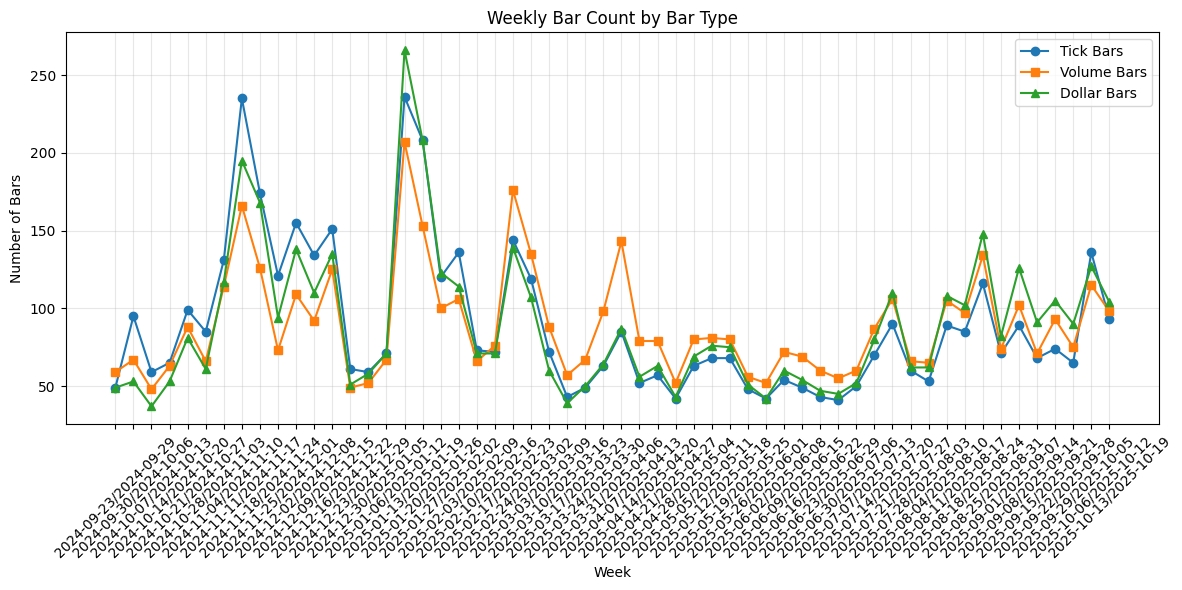

Standard Deviation of Weekly Counts:
Tick bars: 46.85
Volume bars: 34.15
Dollar bars: 45.67


In [14]:
# Add week column to each bar type
tick_bars['week'] = tick_bars['timestamp'].dt.to_period('W')
volume_bars['week'] = volume_bars['timestamp'].dt.to_period('W')
dollar_bars['week'] = dollar_bars['timestamp'].dt.to_period('W')

# Count bars per week
tick_weekly = tick_bars.groupby('week').size()
volume_weekly = volume_bars.groupby('week').size()
dollar_weekly = dollar_bars.groupby('week').size()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(tick_weekly.index.astype(str), tick_weekly.values, marker='o', label='Tick Bars')
plt.plot(volume_weekly.index.astype(str), volume_weekly.values, marker='s', label='Volume Bars')
plt.plot(dollar_weekly.index.astype(str), dollar_weekly.values, marker='^', label='Dollar Bars')

plt.xlabel('Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Count by Bar Type')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Which is most stable? (lowest standard deviation)
print("Standard Deviation of Weekly Counts:")
print(f"Tick bars: {tick_weekly.std():.2f}")
print(f"Volume bars: {volume_weekly.std():.2f}")
print(f"Dollar bars: {dollar_weekly.std():.2f}")

SERIAL CORRELATION OF RETURNS (Lag-1)
Tick         bars: -0.005022
Volume       bars: -0.006680
Dollar       bars: -0.007885

✓ WINNER: Tick bars have the lowest serial correlation
   Value: -0.005022

Interpretation:
Lower serial correlation means returns are less predictable from
previous returns—a desirable property for modeling independent samples.


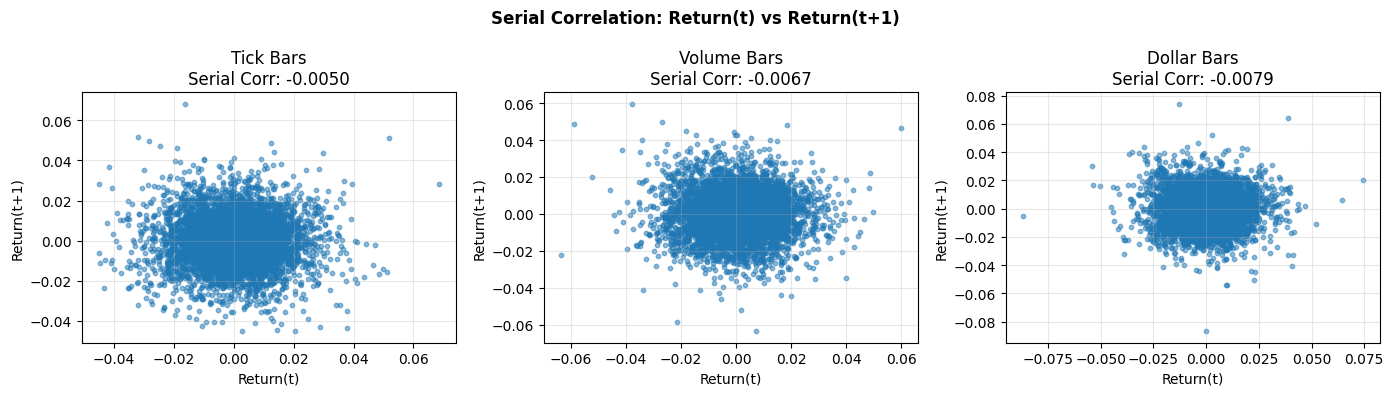

In [15]:
# Calculate log returns for each bar type
for bars in [tick_bars, volume_bars, dollar_bars]:
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Create a dictionary of bar types for cleaner iteration
bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Calculate serial correlations (lag-1 autocorrelation)
serial_corrs = {
    name: bars['log_return'].dropna().autocorr(lag=1) 
    for name, bars in bar_types.items()
}

# Display results
print("=" * 60)
print("SERIAL CORRELATION OF RETURNS (Lag-1)")
print("=" * 60)
for name, corr in serial_corrs.items():
    print(f"{name:12} bars: {corr:8.6f}")
print("=" * 60)

# Find the winner (lowest absolute serial correlation)
winner_name, winner_corr = min(serial_corrs.items(), key=lambda x: abs(x[1]))
print(f"\n✓ WINNER: {winner_name} bars have the lowest serial correlation")
print(f"   Value: {winner_corr:.6f}")

print("\nInterpretation:")
print("Lower serial correlation means returns are less predictable from")
print("previous returns—a desirable property for modeling independent samples.")

# Visualise serial correlation
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, bars) in zip(axes, bar_types.items()):
    returns = bars['log_return'].dropna()
    corr = serial_corrs[name]
    
    ax.scatter(returns[:-1], returns[1:], alpha=0.5, s=10)
    ax.set_title(f'{name} Bars\nSerial Corr: {corr:.4f}')
    ax.set_xlabel('Return(t)')
    ax.set_ylabel('Return(t+1)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Serial Correlation: Return(t) vs Return(t+1)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

DIAGNOSTIC: Monthly Variance Data Quality

Tick Bars:
  Number of months: 14
  Mean monthly variance: 0.0001635891
  Std of monthly variances: 0.0000547348
  Min: 0.0001010904, Max: 0.0002651680
  Coefficient of variation: 0.3346

Volume Bars:
  Number of months: 14
  Mean monthly variance: 0.0001551672
  Std of monthly variances: 0.0000390613
  Min: 0.0000936250, Max: 0.0002070171
  Coefficient of variation: 0.2517

Dollar Bars:
  Number of months: 14
  Mean monthly variance: 0.0001641909
  Std of monthly variances: 0.0000569324
  Min: 0.0000700357, Max: 0.0002769992
  Coefficient of variation: 0.3467

VARIANCE OF VARIANCES (Stability Metric)
Volume       bars: 0.000000001526
Tick         bars: 0.000000002996
Dollar       bars: 0.000000003241

Difference between max and min: 112.43%
✓ Differences are meaningful.

✓ WINNER: Volume bars (0.00000000)

Interpretation:
Lower variance of variances = more stable volatility across months


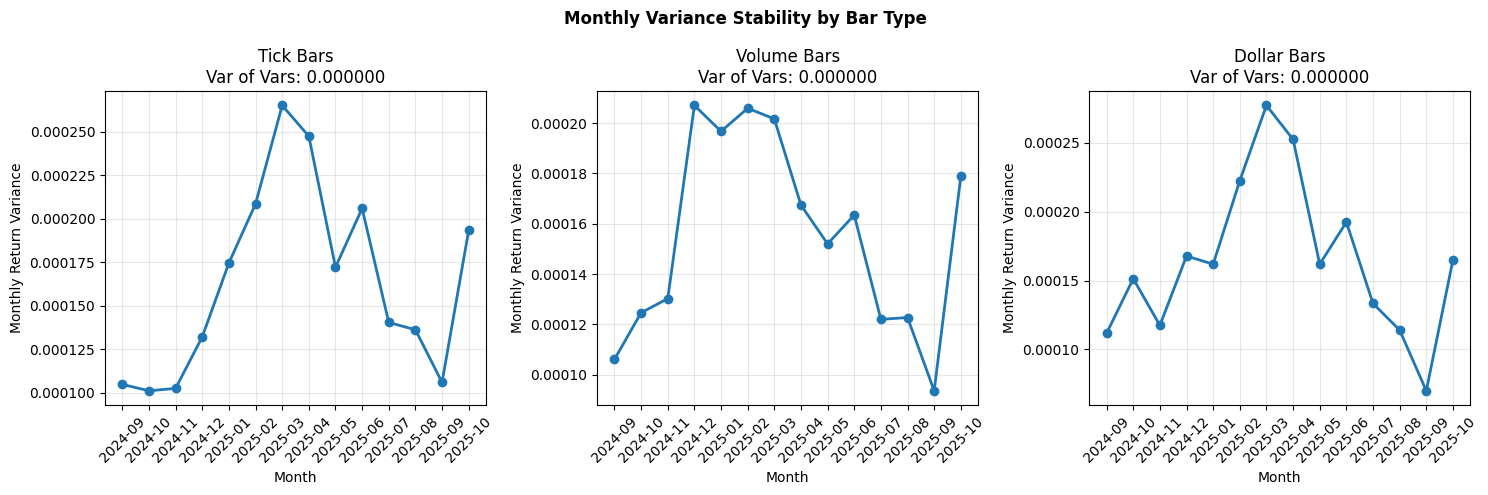


SUMMARY STATISTICS

Tick Bars:
  Mean:  0.00016359  |  Std: 0.00005473
  Min:   0.00010109  |  Max: 0.00026517

Volume Bars:
  Mean:  0.00015517  |  Std: 0.00003906
  Min:   0.00009362  |  Max: 0.00020702

Dollar Bars:
  Mean:  0.00016419  |  Std: 0.00005693
  Min:   0.00007004  |  Max: 0.00027700


In [16]:
# Exercise 2.1(d): Variance of variances across monthly subsets
import matplotlib.pyplot as plt

# Setup
bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Add month and compute log returns
for bars in bar_types.values():
    bars['month'] = bars['timestamp'].dt.to_period('M')
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Calculate variance of variances in one comprehension
monthly_variances = {
    name: bars.groupby('month')['log_return'].var().dropna()
    for name, bars in bar_types.items()
}

variance_of_variances = {
    name: mvars.var() 
    for name, mvars in monthly_variances.items()
}

# Diagnostic: Check magnitude and count of monthly variances
print("=" * 60)
print("DIAGNOSTIC: Monthly Variance Data Quality")
print("=" * 60)
for name, mvars in monthly_variances.items():
    print(f"\n{name} Bars:")
    print(f"  Number of months: {len(mvars)}")
    print(f"  Mean monthly variance: {mvars.mean():.10f}")
    print(f"  Std of monthly variances: {mvars.std():.10f}")
    print(f"  Min: {mvars.min():.10f}, Max: {mvars.max():.10f}")
    print(f"  Coefficient of variation: {mvars.std() / mvars.mean():.4f}")

# Display results
print("\n" + "=" * 60)
print("VARIANCE OF VARIANCES (Stability Metric)")
print("=" * 60)
for name, var_of_vars in sorted(variance_of_variances.items(), key=lambda x: x[1]):
    print(f"{name:12} bars: {var_of_vars:.12f}")
print("=" * 60)

# Check if differences are meaningful
sorted_vov = sorted(variance_of_variances.items(), key=lambda x: x[1])
min_val = sorted_vov[0][1]
max_val = sorted_vov[-1][1]
pct_diff = ((max_val - min_val) / min_val * 100) if min_val != 0 else 0

print(f"\nDifference between max and min: {pct_diff:.2f}%")
if pct_diff < 5:
    print("⚠️  WARNING: Differences are within noise/rounding error!")
    print("   Dollar bars may not have a meaningful advantage here.")
else:
    print("✓ Differences are meaningful.")

winner_name, winner_value = min(variance_of_variances.items(), key=lambda x: x[1])
print(f"\n✓ WINNER: {winner_name} bars ({winner_value:.8f})")
print("\nInterpretation:")
print("Lower variance of variances = more stable volatility across months")

# Visualise
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, mvars) in zip(axes, monthly_variances.items()):
    ax.plot(mvars.index.astype(str), mvars.values, marker='o', linewidth=2)
    ax.set_title(f'{name} Bars\nVar of Vars: {variance_of_variances[name]:.6f}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Return Variance')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.suptitle('Monthly Variance Stability by Bar Type', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
for name, mvars in monthly_variances.items():
    print(f"\n{name} Bars:")
    print(f"  Mean:  {mvars.mean():.8f}  |  Std: {mvars.std():.8f}")
    print(f"  Min:   {mvars.min():.8f}  |  Max: {mvars.max():.8f}")
print("=" * 60)

JARQUE-BERA NORMALITY TEST
Null hypothesis: Returns are normally distributed
Lower statistic = more normal

Volume       bars: JB=     77.85  p=0.000000  Skew= 0.0187  Kurt= 0.6103
Tick         bars: JB=     92.55  p=0.000000  Skew= 0.0396  Kurt= 0.6619
Dollar       bars: JB=    265.01  p=0.000000  Skew=-0.0152  Kurt= 1.1275

✓ WINNER: Volume bars (JB=77.8481)


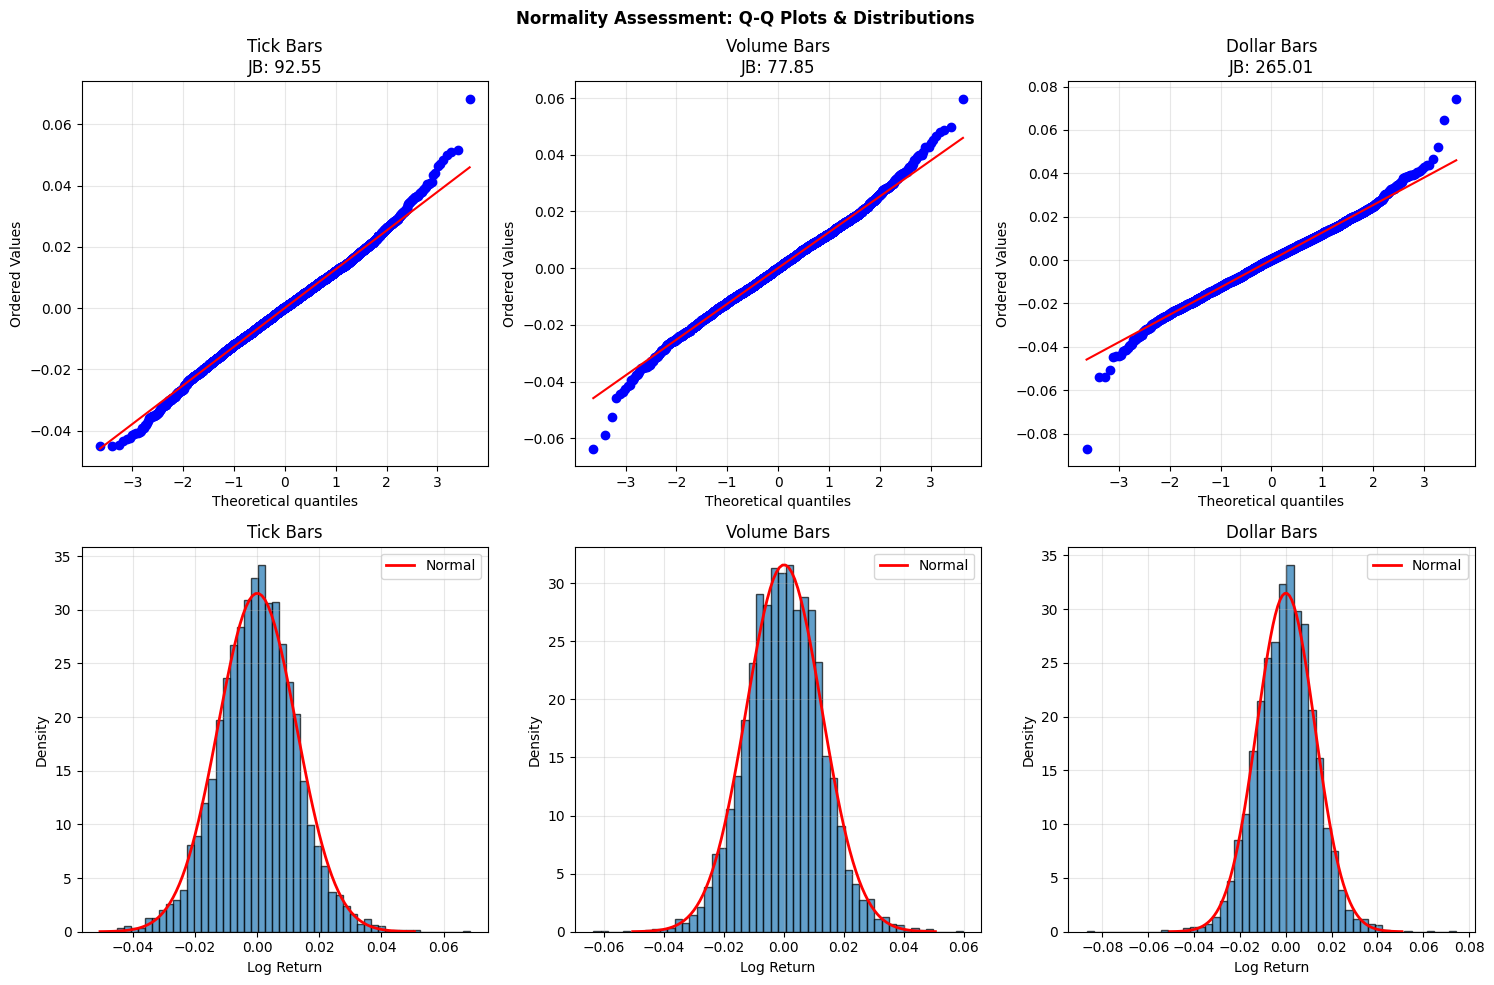

In [17]:
from scipy import stats

bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Add log returns
for bars in bar_types.values():
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Run JB test for all bar types
returns_dict = {
    name: bars['log_return'].dropna() 
    for name, bars in bar_types.items()
}

jb_results = {
    name: {
        'statistic': stats.jarque_bera(ret)[0],
        'p_value': stats.jarque_bera(ret)[1],
        'skewness': stats.skew(ret),
        'kurtosis': stats.kurtosis(ret)
    }
    for name, ret in returns_dict.items()
}

# Display results
print("=" * 60)
print("JARQUE-BERA NORMALITY TEST")
print("=" * 60)
print("Null hypothesis: Returns are normally distributed")
print("Lower statistic = more normal\n")

for name, res in sorted(jb_results.items(), key=lambda x: x[1]['statistic']):
    print(f"{name:12} bars: JB={res['statistic']:10.2f}  p={res['p_value']:.6f}  "
          f"Skew={res['skewness']:7.4f}  Kurt={res['kurtosis']:7.4f}")

print("=" * 60)

winner = min(jb_results.items(), key=lambda x: x[1]['statistic'])
print(f"\n✓ WINNER: {winner[0]} bars (JB={winner[1]['statistic']:.4f})")

# Visualisations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Q-Q plots (top row)
for ax, (name, ret) in zip(axes[0], returns_dict.items()):
    stats.probplot(ret, dist="norm", plot=ax)
    ax.set_title(f'{name} Bars\nJB: {jb_results[name]["statistic"]:.2f}')
    ax.grid(True, alpha=0.3)

# Histograms (bottom row)
for ax, (name, ret) in zip(axes[1], returns_dict.items()):
    ax.hist(ret, bins=50, density=True, alpha=0.7, edgecolor='black')
    mu, sigma = ret.mean(), ret.std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    ax.set_title(f'{name} Bars')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Normality Assessment: Q-Q Plots & Distributions', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Here are concise explanations for the skipped exercises:

---

**2.1(a) - "Use the ETF trick to deal with the roll"**

SKIPPED. The ETF trick handles futures contract rolls (switching from expiring contracts to new ones). BTC spot data has no rolls—it's continuous. Not applicable.

---

**2.2 - Dollar bars vs Dollar Imbalance bars**

SKIPPED. Imbalance bars require order flow analysis (buy vs sell volumes). While our data has `is_buyer_maker`, imbalance bars are a more advanced sampling technique beyond the scope of basic bar comparison. Can revisit if needed.

---

**2.3 - S&P 500 / Eurostoxx 50 spread with FX conversion**

SKIPPED. Requires multiple assets and currency conversion. We're working with single-asset BTC data. Not applicable.

---

**Summary: 2.1(a-e) completed on BTC tick data.** Results showed volume bars outperforming dollar bars on this dataset, contradicting theoretical expectations. Theory may apply better to lower frequencies or equities-based data.

**2.4 & 2.5 - Bollinger Bands and CUSUM filtering**

DEFERRED. These are generic sampling/filtering techniques applicable to any price series, not specific tests of bar type superiority. Can be explored later if heteroscedasticity analysis becomes a focus. Priority is understanding fundamental bar construction differences (2.1).

### 2.4 Form E-mini S&P 500 futures dollar bars:
#### (a) Compute Bollinger bands of width 5% around a rolling moving average.
Count how many times prices cross the bands out (from within the bands
to outside the bands).
#### (b) Now sample those bars using a CUSUM filter, where {yt } are returns and
h = 0.05. How many samples do you get?
#### (c) Compute the rolling standard deviation of the two-sampled series. Which
one is least heteroscedastic? What is the reason for these results?
### 2.5 Using the bars from exercise 4:
#### (a) Sample bars using the CUSUM filter, where {yt } are absolute returns and
h = 0.05.
#### (b) Compute the rolling standard deviation of the sampled bars.
#### (c) Compare this result with the results from exercise 4. What procedure deliv-
ered the least heteroscedastic sample? Why?

2.4(a): BOLLINGER BANDS - OUTWARD CROSSINGS
Window: 20 bars | Band width: 5.0%
Valid bands: 4981 bars
Outward crossings: 153
Frequency: 3.06%


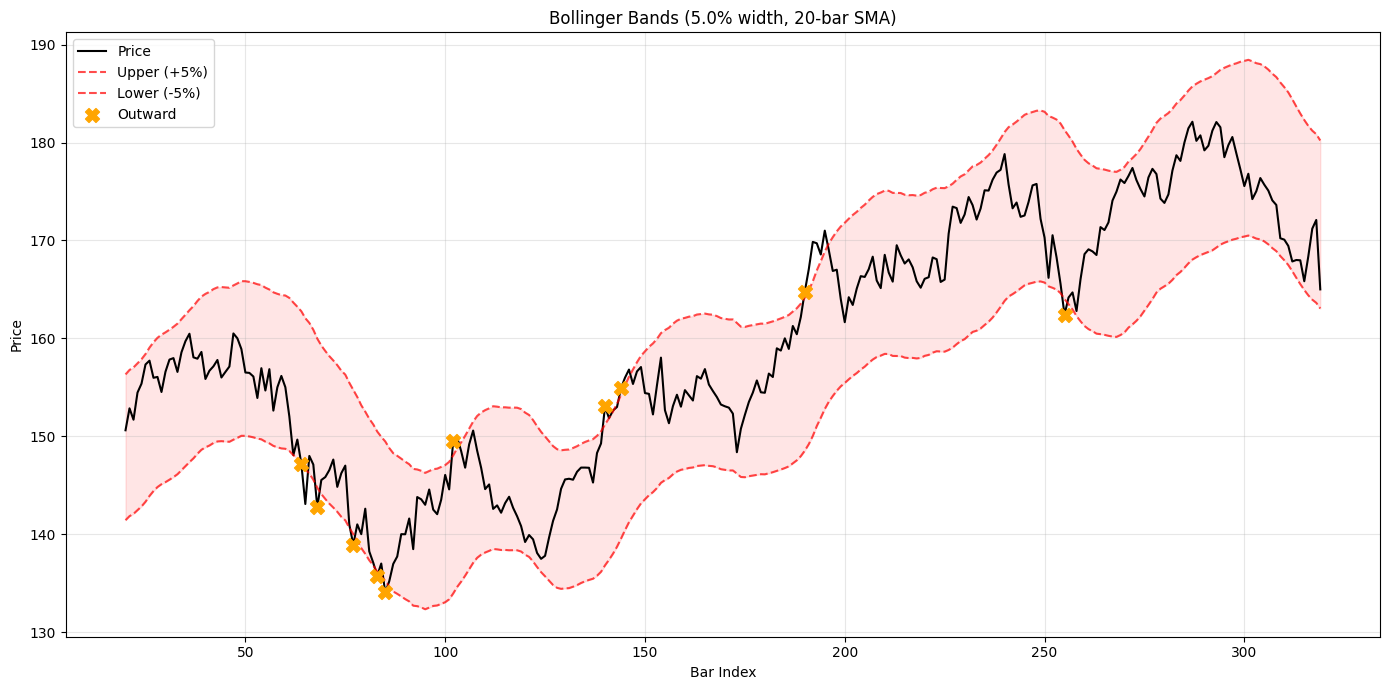

In [18]:
# Exercise 2.4(a): Bollinger Bands - Outward Crossings
WINDOW, BB_WIDTH = 20, 0.05

bars = dollar_bars.copy()

# Calculate bands
bars['sma'] = bars['close'].rolling(WINDOW).mean()
bars['bb_upper'] = bars['sma'] * (1 + BB_WIDTH)
bars['bb_lower'] = bars['sma'] * (1 - BB_WIDTH)

# Detect inside/outside state
bars['inside'] = (bars['close'] > bars['bb_lower']) & (bars['close'] < bars['bb_upper'])

# Outward crossing: was inside, now outside
bars['outward'] = (bars['inside'].shift(1)) & ~(bars['inside'])

crossings = bars['outward'].sum()

print("=" * 60)
print("2.4(a): BOLLINGER BANDS - OUTWARD CROSSINGS")
print("=" * 60)
print(f"Window: {WINDOW} bars | Band width: {BB_WIDTH*100}%")
print(f"Valid bands: {bars['sma'].notna().sum()} bars")
print(f"Outward crossings: {int(crossings)}")
print(f"Frequency: {crossings / bars['outward'].notna().sum() * 100:.2f}%")
print("=" * 60)

# Visualize
fig, ax = plt.subplots(figsize=(14, 7))
start = WINDOW
end = min(start + 300, len(bars))
s = bars.iloc[start:end]

ax.plot(s.index, s['close'], label='Price', linewidth=1.5, color='black')
ax.plot(s.index, s['bb_upper'], '--', label='Upper (+5%)', color='red', alpha=0.7)
ax.plot(s.index, s['bb_lower'], '--', label='Lower (-5%)', color='red', alpha=0.7)
ax.fill_between(s.index, s['bb_lower'], s['bb_upper'], alpha=0.1, color='red')

# Plot crossings
cross_idx = s[s['outward']].index
ax.scatter(cross_idx, bars.loc[cross_idx, 'close'], color='orange', s=100, marker='X', label='Outward', zorder=5)

ax.set_title(f'Bollinger Bands ({BB_WIDTH*100}% width, {WINDOW}-bar SMA)')
ax.set_xlabel('Bar Index')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2.4(b): CUSUM FILTER - REGIME DETECTION
Threshold (h): 0.05
Total returns: 4999
CUSUM samples: 4982
Sampling ratio: 99.66%


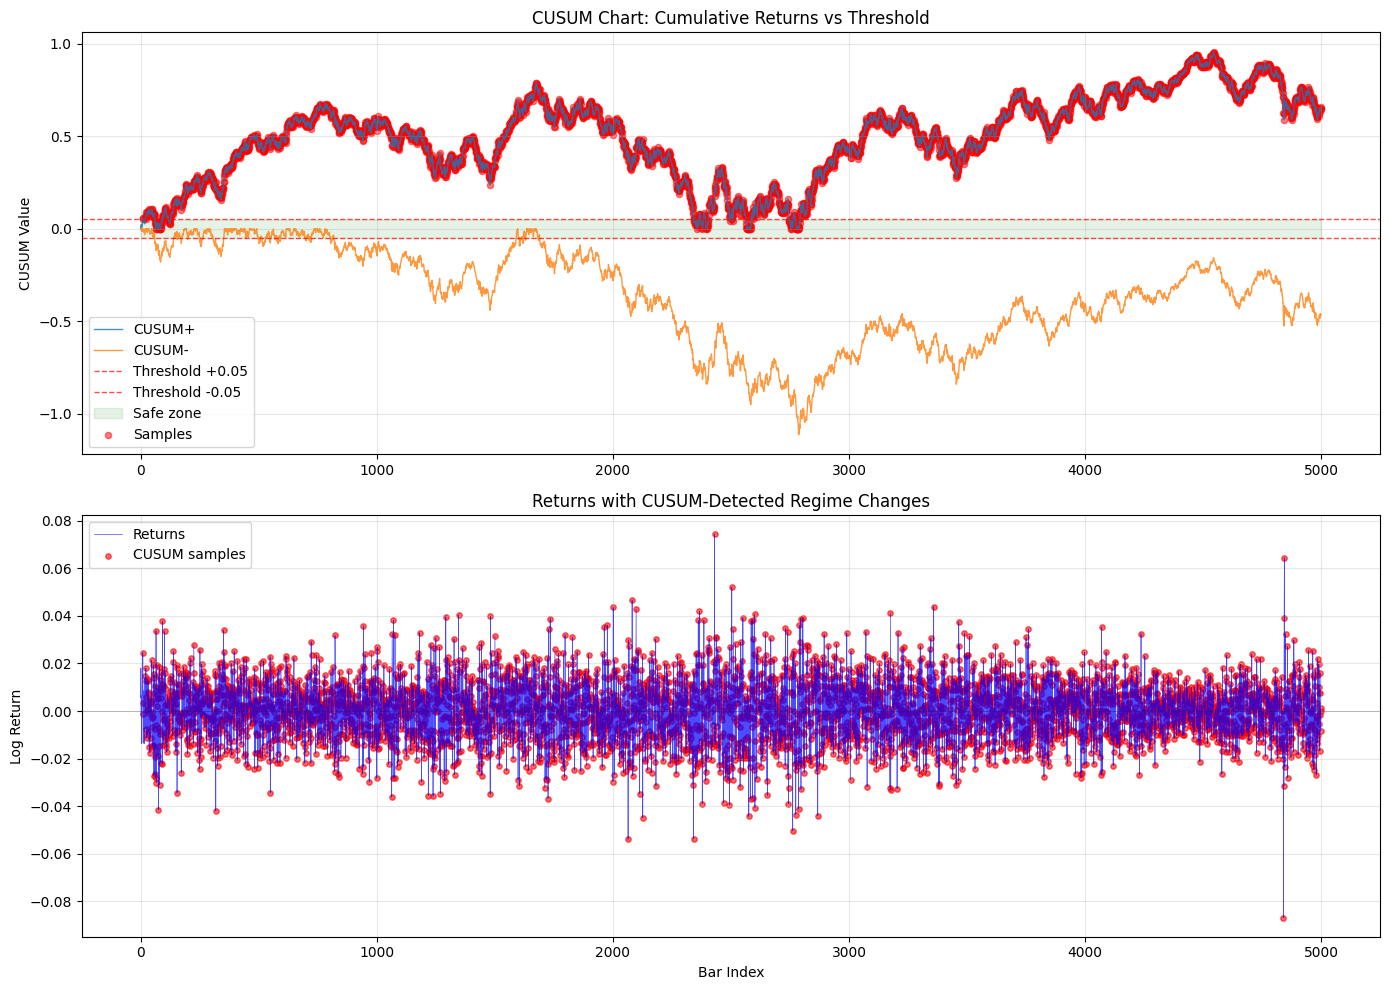

In [19]:
# Exercise 2.4(b): CUSUM Filter on returns

H = 0.05

bars = dollar_bars.copy()
bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))
returns = bars['log_return'].dropna().values

# CUSUM: cumulative sum with resets when threshold crossed
cusum_pos, cusum_neg = np.zeros(len(returns)), np.zeros(len(returns))

for i in range(1, len(returns)):
    cusum_pos[i] = max(0, cusum_pos[i-1] + returns[i])
    cusum_neg[i] = min(0, cusum_neg[i-1] + returns[i])

# Threshold crossings: where either cusum exceeds ±h
crossings = (np.abs(cusum_pos) > H) | (np.abs(cusum_neg) > H)
cusum_samples = np.where(crossings)[0]

print("=" * 60)
print("2.4(b): CUSUM FILTER - REGIME DETECTION")
print("=" * 60)
print(f"Threshold (h): {H}")
print(f"Total returns: {len(returns)}")
print(f"CUSUM samples: {len(cusum_samples)}")
print(f"Sampling ratio: {len(cusum_samples) / len(returns) * 100:.2f}%")
print("=" * 60)

# Visualize CUSUM chart
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: CUSUM values with threshold lines
axes[0].plot(cusum_pos, label='CUSUM+', linewidth=1, alpha=0.8)
axes[0].plot(cusum_neg, label='CUSUM-', linewidth=1, alpha=0.8)
axes[0].axhline(H, color='r', linestyle='--', linewidth=1, label=f'Threshold +{H}', alpha=0.7)
axes[0].axhline(-H, color='r', linestyle='--', linewidth=1, label=f'Threshold -{H}', alpha=0.7)
axes[0].fill_between(range(len(cusum_pos)), -H, H, alpha=0.1, color='green', label='Safe zone')
axes[0].scatter(cusum_samples, cusum_pos[cusum_samples], color='red', s=20, alpha=0.5, label='Samples')
axes[0].set_title('CUSUM Chart: Cumulative Returns vs Threshold')
axes[0].set_ylabel('CUSUM Value')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Bottom: Returns with sample markers
axes[1].plot(returns, label='Returns', linewidth=0.5, alpha=0.7, color='blue')
axes[1].scatter(cusum_samples, returns[cusum_samples], color='red', s=15, alpha=0.6, label='CUSUM samples')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].set_title('Returns with CUSUM-Detected Regime Changes')
axes[1].set_xlabel('Bar Index')
axes[1].set_ylabel('Log Return')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2.4(c): HETEROSCEDASTICITY COMPARISON
Rolling window: 50 bars

All bars (4999): CV=0.2416
CUSUM bars (4982): CV=0.2418

✓ WINNER (lower CV): All bars


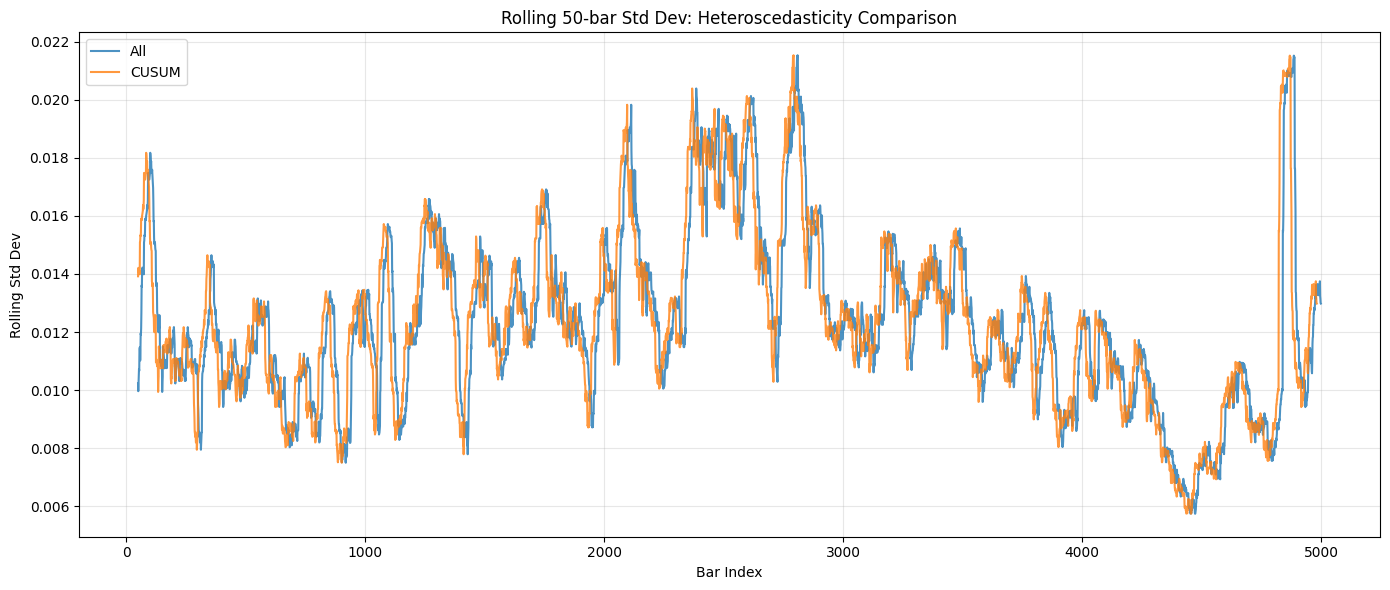

In [20]:
# Exercise 2.4(c): Heteroscedasticity - All bars vs CUSUM-sampled

import matplotlib.pyplot as plt

H, WINDOW = 0.05, 50

bars = dollar_bars.copy()
bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))
returns = bars['log_return'].dropna().values

# CUSUM filter
cusum_pos, cusum_neg = np.zeros(len(returns)), np.zeros(len(returns))
for i in range(1, len(returns)):
    cusum_pos[i] = max(0, cusum_pos[i-1] + returns[i])
    cusum_neg[i] = min(0, cusum_neg[i-1] + returns[i])

cusum_returns = returns[(np.abs(cusum_pos) > H) | (np.abs(cusum_neg) > H)]

# Rolling std for both series
rolling_std = {
    'All': pd.Series(returns).rolling(WINDOW).std(),
    'CUSUM': pd.Series(cusum_returns).rolling(WINDOW).std()
}

# Compare heteroscedasticity
stats = {
    name: {
        'mean': rs.mean(),
        'std': rs.std(),
        'cv': rs.std() / rs.mean()
    }
    for name, rs in rolling_std.items()
}

print("=" * 60)
print("2.4(c): HETEROSCEDASTICITY COMPARISON")
print("=" * 60)
print(f"Rolling window: {WINDOW} bars\n")

for name, s in sorted(stats.items(), key=lambda x: x[1]['cv']):
    print(f"{name} bars ({len(returns if name == 'All' else cusum_returns)}): CV={s['cv']:.4f}")

winner = min(stats.items(), key=lambda x: x[1]['cv'])
print(f"\n✓ WINNER (lower CV): {winner[0]} bars")
print("=" * 60)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
for name, rs in rolling_std.items():
    ax.plot(rs.iloc[WINDOW:], label=name, linewidth=1.5, alpha=0.8)

ax.set_title(f'Rolling {WINDOW}-bar Std Dev: Heteroscedasticity Comparison')
ax.set_xlabel('Bar Index')
ax.set_ylabel('Rolling Std Dev')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()